# Location Classification
The goal of this notebook is to find important lab tests per location of (positive) uveitis patients. 
The hypothesis is that an anterior inflammation can be identified by a different subset of lab tests as for example posterior inflammations. 
This would allow to order a subset of all possible lab tests after the location of the inflammation has been located to identify uveitis. One approach would be to train a model per location.

Steps:

1. Get Subset of Data (Target Featue: Location, Input Features: Lab Results) 
2. Define suitable Algorithms for Binary Classification (e.g. Logistic Regression, etc.)
3. Call preprocessing pipe with appropriat parameters for the current algorithm
4. Fit Model
5. Extract and Discuss important Features

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn standard imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# !pip install scikit-optimize # = skopt
from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, f1_score, precision_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from dtreeviz.trees import dtreeviz
from sklearn.metrics import plot_confusion_matrix


# import of pipe module
os.chdir('../preprocessing/')
import pipe

os.chdir('../machine_learning/')
import helpers


RANDOM = 43
# SCORER = make_scorer(f1_score, average='macro')
SCORER = make_scorer(balanced_accuracy_score)
def SCORE(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred)

def get_feature_names(pipeline_object):
    num_feat = pipeline_object[0].transformers_[0][2]
    try:
        one_hot_feat = pipeline_object[0].transformers_[1][1]['onehot'].get_feature_names(categorical_features)
    except:
        return X.columns
    return list(num_feat) + list(one_hot_feat)

def plot_featureimportance(pipeline_object):
    a = pd.DataFrame()
    a['value'] = pipeline_object[1].feature_importances_
    a['feature'] = get_feature_names(pipeline_object)
    a = a.sort_values(by='value', ascending=False)
    plt.figure(figsize=(10,7))
    g = sns.barplot(y=a.feature, x=a.value*100, data= a, color = 'steelblue')
    helpers.plot_wrapper(g, 'Feature Importances', None, 'Percentage', 'Feature Name')

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [2]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

gender           loc  calcium  lactate_dehydrogenase  \
0    Male      anterior     2.27                    184   
1  Female  intermediate     2.32                    209   
2  Female    panuveitis     2.44                    194   
3  Female      anterior     2.45                    156   
4  Female      anterior     2.28                    175   

   c-reactive_protein,_normal_and_high_sensitivity   wbc   rbc  hemoglobin  \
0                                            1.830  6.91  4.97        14.6   
1                                            0.150  4.24  4.22        11.0   
2                                            0.137  6.38  4.31        13.6   
3                                            3.500  5.24  4.82        14.6   
4                                            1.000  8.31  4.72        14.0   

   hematocrit   mcv  ...  lysozyme,_plasma  anti-ccp_ab  anti-ena_screen  \
0        41.4  83.3  ...               3.0          0.0              0.0   
1        36.0  85.3  ...               NaN          0.0              0.0   
2        38.7  89.8  ...               4.8          0.0              0.0   
3        43.6  90.5  ...               NaN          0.0              0.0   
4        40.7  86.2  ...               4.5          0.0              0.0   

   antinuclear_antibody  dna_double-stranded_ab  rheumatoid_factor  hbc__ab  \
0                   0.0                     0.0                  0        0   
1                   0.0                     0.0                  0        0   
2                   0.0                     0.0                  0        0   
3                   0.0                     0.0                  0        0   
4                   0.0                     1.0                  0        0   

   hbs__ag  hcv__ab  uveitis  
0        0        0    False  
1        0        0     True  
2        0        0     True  
3        0        0     True  
4        0        0     True  

[5 rows x 27 columns]

### Split into uveitis and not_uveitis data

In [3]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

# Multiclass classification
In this section we try to predict the location of an inflammation of uveitis positive patients. For this we remove records of non uveitis patients.
These models can be used as a comparison for the binary classification (see next chapter)

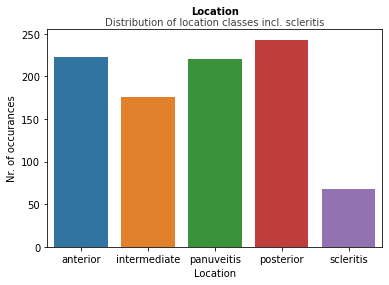

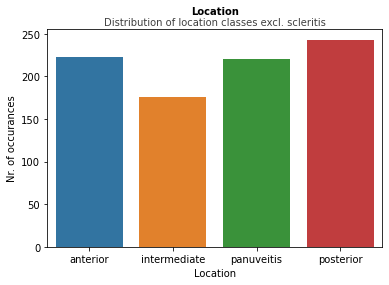

In [4]:
df_uv_pos_clean = df_uv_pos.dropna(subset=['loc']) # drop records with missing location data (3)


g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes incl. scleritis','Location','Nr. of occurances')

# remove category scleritis
df_uv_pos_clean = df_uv_pos_clean[df_uv_pos_clean['loc'] != 'scleritis']
df_uv_pos_clean['loc'] = df_uv_pos_clean['loc'].cat.remove_unused_categories()

g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes excl. scleritis','Location','Nr. of occurances')

**Discussion** The target feature contains 5 classes. The three missing values have been removed. We can see that, with the execption of the location 'scleritis', that the classes are somewhat balanced. We remove the records with location 'scleritis' as upsampling or downsampling is not an option for this dataset. Because it is a minority class, it can negatively impact the prediction for every other class.

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the loc (Location)-Feature. 
The target feature contains 3 missing values. We initially drop these records.

We pose the hypothesis that splitting the data into a male and female subset yields better results for the machine learning algorithmns. Thus we create 3 datasets. One containing all records with uveitits `X`, one containing only the male data `X_m` (the `m` stands for "male") and one containing only the female data `X_f` (the `f`stands for "female")

In [5]:
# train_test_split
X = df_uv_pos_clean.drop(columns=['loc','uveitis','gender'])
y = df_uv_pos_clean['loc']

X_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male'].drop(columns=['loc','uveitis','gender'])
X_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female'].drop(columns=['loc','uveitis','gender'])
y_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male']['loc']
y_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female']['loc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=RANDOM, stratify = y_m)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25, random_state=RANDOM, stratify = y_f)

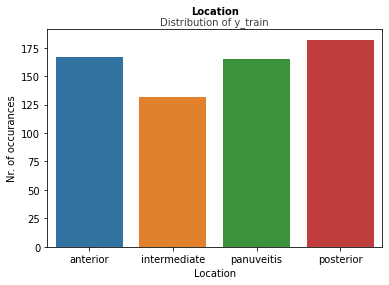

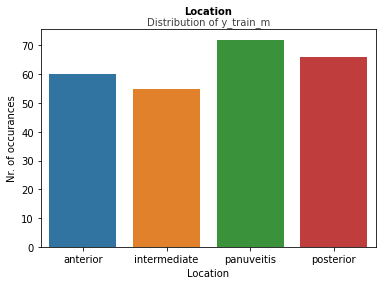

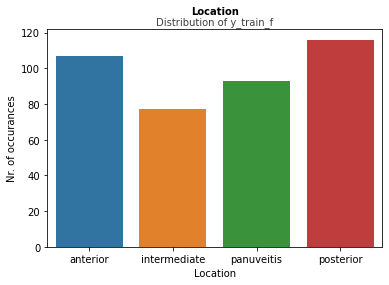

In [6]:
g = sns.countplot(x=y_train)
helpers.plot_wrapper(g, 'Location','Distribution of y_train','Location','Nr. of occurances')
g = sns.countplot(x=y_train_m)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_m','Location','Nr. of occurances')
g = sns.countplot(x=y_train_f)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_f','Location','Nr. of occurances')

**Discussion** The three countplots show the distribution of the target feature for after the train-test Split for the whole dataset and the male/female datasets.

#### Imputation and Encoding

In [7]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=False)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_onehot_knn # imputer_encoder_onehot yields best results so far 

We test multiple strategies for imputing missing values and encoding the data for later use with machine learning algorithms:

1. No OneHotEncoding of categorical features, categories will be Label Encoded. (with LabelEncoder), strategy for imputation: 
    Categorical Features: Most Frequent, Numerical Features: Median value.
2. OneHotEncoding of categorical features, strategy for imputation:
    Same as in Number 1
3. OneHotEncoding and imputation of missing values with a KNN Algorithmn.
4. No OneHotEncoding and imputation of missing values with a KNN Algorithmn.

## 3-Dimensional Data Representation

In [8]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train.values,
                   title="PCA representation of uveitits positive training data", labels={"0":"PC1","1":"PC2","2":"PC3"}, opacity=1,
                   width=800, height=800, size_max=.5)
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.13 %


In [9]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_m)

fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_m.values,
                   title="PCA representation of uveitits positive training data (male only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.27 %


In [10]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_f)

fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_f.values,
                   title="PCA representation of uveitits positive training data (female only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.67 %


The graphics above represent all three datasets in the first 3 Principal Components. We retain about 40% of the variance for all 3 datasets. We see hardly any distinguishable clusters in the data. It seems that the data will be hard to classify.

## Baseline Model
This model acts as our basline. This model takes in the prior probability of a class occuring in the trainingset, and recommends blindly based on these probabilites. 
### Complete positive data

In [11]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train, y_train)
print(f'Score Dummy Classifier: {SCORE(y_test, pipeline.predict(X_test))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.2427227485629125
Class probabilites: [0.25851393 0.20433437 0.25541796 0.28173375]


### Male positive data

In [12]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_m, y_train_m)
print(f'Score Dummy Classifier: {SCORE(y_test_m, pipeline.predict(X_test_m))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.3286682615629984
Class probabilites: [0.23715415 0.2173913  0.28458498 0.26086957]


### Female positive data

In [13]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_f, y_train_f)
print(f'Score Dummy Classifier: {SCORE(y_test_f, pipeline.predict(X_test_f))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.2544216983733113
Class probabilites: [0.27226463 0.19592875 0.23664122 0.29516539]


## Decision Tree

### Complete positive data

Score: 0.29004550777091764
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 8, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'best'}
              precision    recall  f1-score   support

    anterior       0.25      0.27      0.26        56
intermediate       0.27      0.43      0.33        44
  panuveitis       0.26      0.18      0.22        55
   posterior       0.35      0.28      0.31        61

    accuracy                           0.28       216
   macro avg       0.28      0.29      0.28       216
weighted avg       0.29      0.28      0.28       216

Standarddeviation Score: 0.012928177981574872


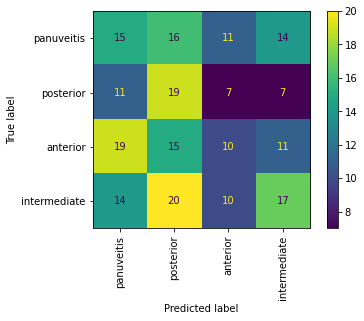

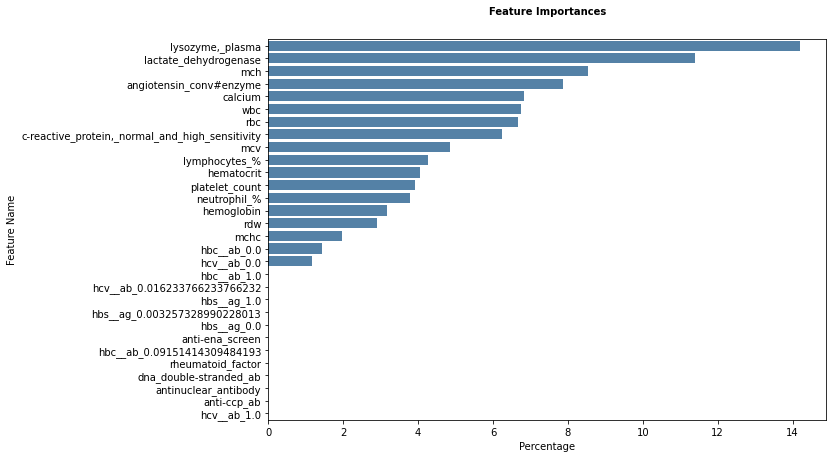

In [14]:
# supress warnings of estimator fit failed
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def dec_tree(X_train, X_test, y_train, y_test):
    dectree = DecisionTreeClassifier(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', dectree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__criterion':['gini','entropy'],
        'tree__splitter' :['best','random'],
        'tree__max_depth':np.arange(2,20,2),
        'tree__min_samples_split':[int(i) for i in np.arange(2,20,10)],
        'tree__random_state':[RANDOM],
        'tree__class_weight':['balanced', None] # balanced = inverse proportional importance per class
    }

    # grid search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

dec_tree(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.24704944178628388
Best Parameters:
{'tree__class_weight': None, 'tree__criterion': 'entropy', 'tree__max_depth': 8, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'random'}
              precision    recall  f1-score   support

    anterior       0.12      0.05      0.07        20
intermediate       0.50      0.16      0.24        19
  panuveitis       0.23      0.42      0.30        24
   posterior       0.29      0.36      0.32        22

    accuracy                           0.26        85
   macro avg       0.29      0.25      0.23        85
weighted avg       0.28      0.26      0.24        85

Standarddeviation Score: 0.07056575115313904


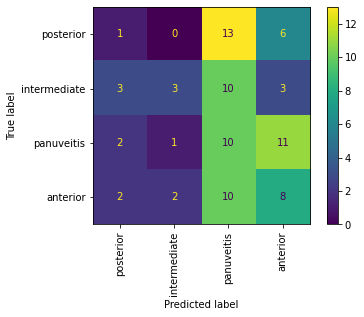

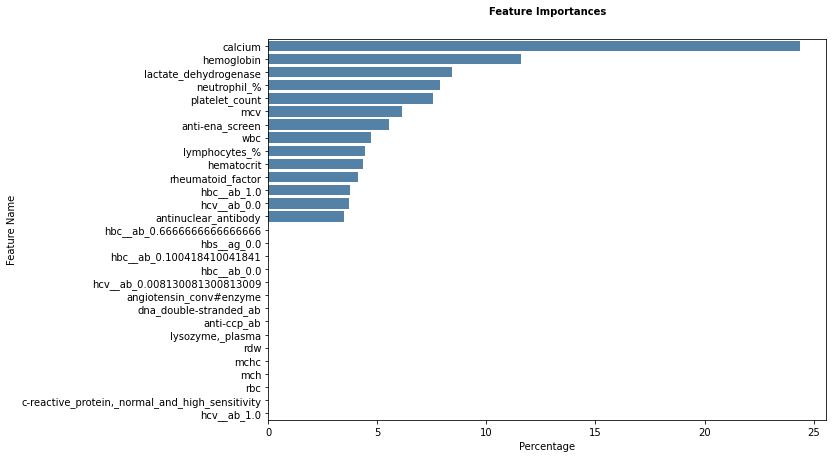

In [15]:
dec_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.23440377722635786
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 18, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'random'}
              precision    recall  f1-score   support

    anterior       0.29      0.31      0.30        36
intermediate       0.15      0.24      0.18        25
  panuveitis       0.19      0.16      0.18        31
   posterior       0.35      0.23      0.28        39

    accuracy                           0.24       131
   macro avg       0.24      0.23      0.23       131
weighted avg       0.26      0.24      0.24       131

Standarddeviation Score: 0.03135231654291547


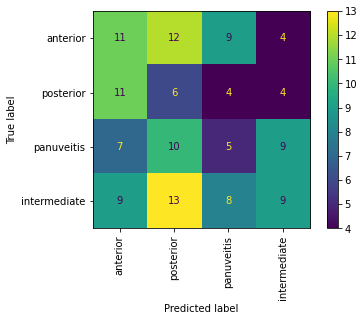

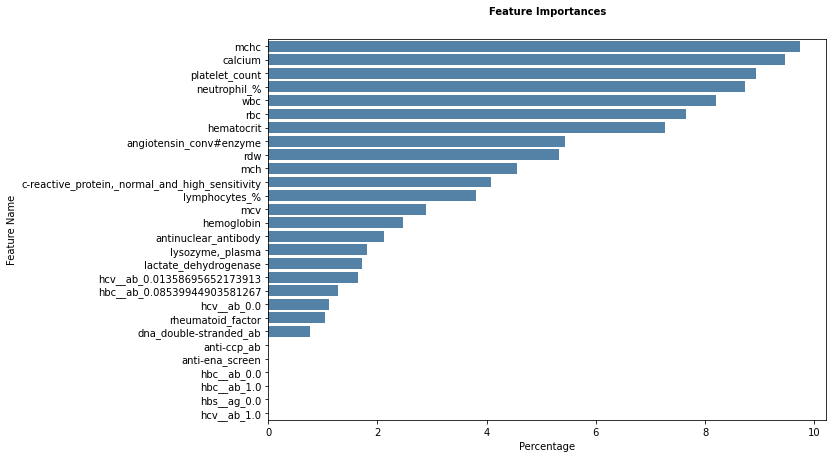

In [16]:
dec_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## Random Forest
### Complete positive data

Score: 0.2671519054715776
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 100, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.24      0.21      0.23        56
intermediate       0.21      0.20      0.21        44
  panuveitis       0.26      0.27      0.27        55
   posterior       0.35      0.38      0.36        61

    accuracy                           0.27       216
   macro avg       0.27      0.27      0.27       216
weighted avg       0.27      0.27      0.27       216

Standarddeviation Score: 0.029991332743190248


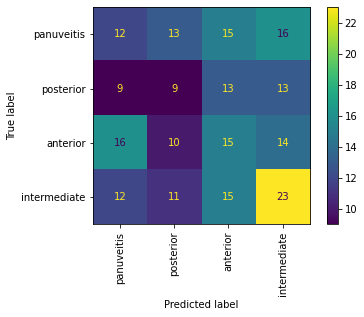

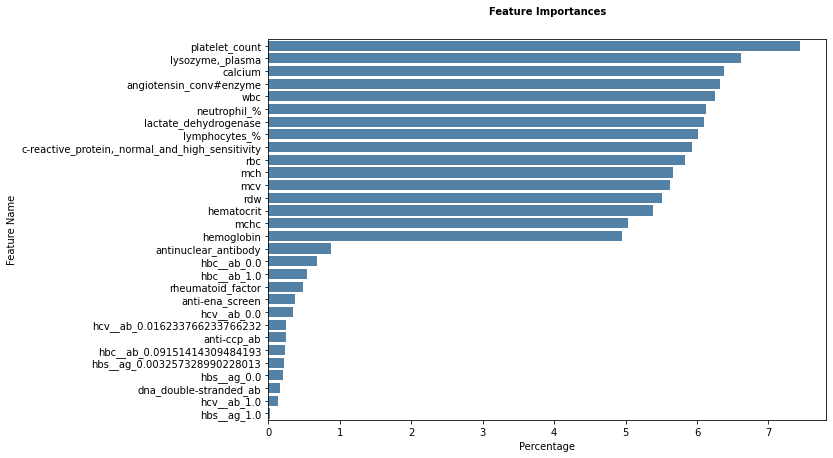

In [17]:
from sklearn.ensemble import RandomForestClassifier

def ran_tree(X_train, X_test, y_train, y_test):
    rantree = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', rantree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__n_estimators':[100,1000],
        'tree__max_features':['log2', 'sqrt', 'auto'],
        'tree__oob_score':[True,False]
    }

    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv.best_estimator_, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    plot_featureimportance(bv.best_estimator_)

    
ran_tree(X_train, X_test, y_train, y_test)

In [18]:
# helpers.plot_validation_curve(bv.best_estimator_.fit(X_train, y_train), X_test, y_test, 'tree__n_estimators',np.arange(10,100,10), scorer)

### Male positive data

Score: 0.24145733652312598
Best Parameters:
{'tree__max_features': 'sqrt', 'tree__n_estimators': 1000, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.17      0.10      0.12        20
intermediate       0.20      0.21      0.21        19
  panuveitis       0.26      0.29      0.27        24
   posterior       0.31      0.36      0.33        22

    accuracy                           0.25        85
   macro avg       0.23      0.24      0.23        85
weighted avg       0.24      0.25      0.24        85

Standarddeviation Score: 0.024427183047392404


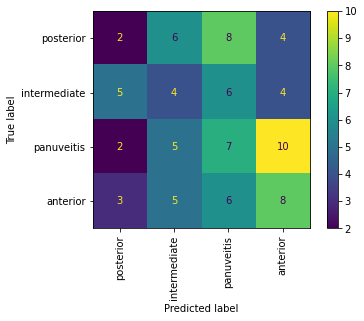

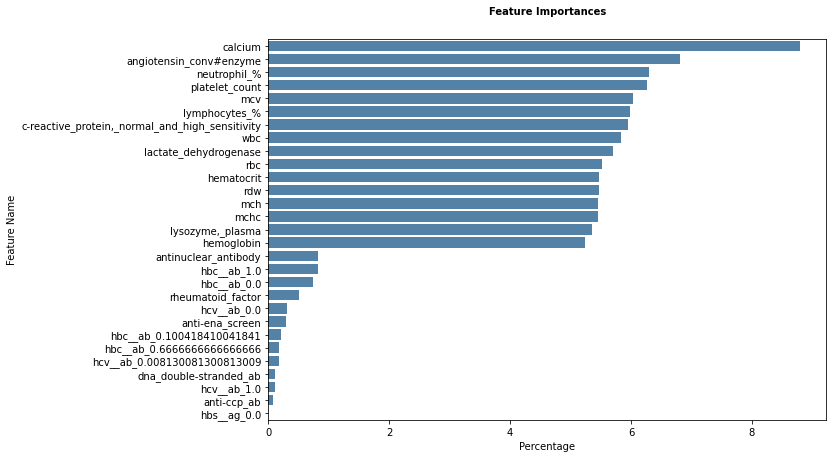

In [19]:
ran_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.32139647091259993
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 1000, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.29      0.28      0.29        36
intermediate       0.25      0.16      0.20        25
  panuveitis       0.30      0.26      0.28        31
   posterior       0.43      0.59      0.49        39

    accuracy                           0.34       131
   macro avg       0.32      0.32      0.31       131
weighted avg       0.33      0.34      0.33       131

Standarddeviation Score: 0.03777562976219235


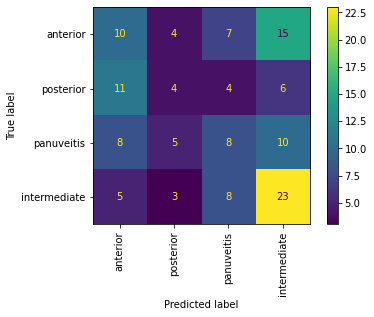

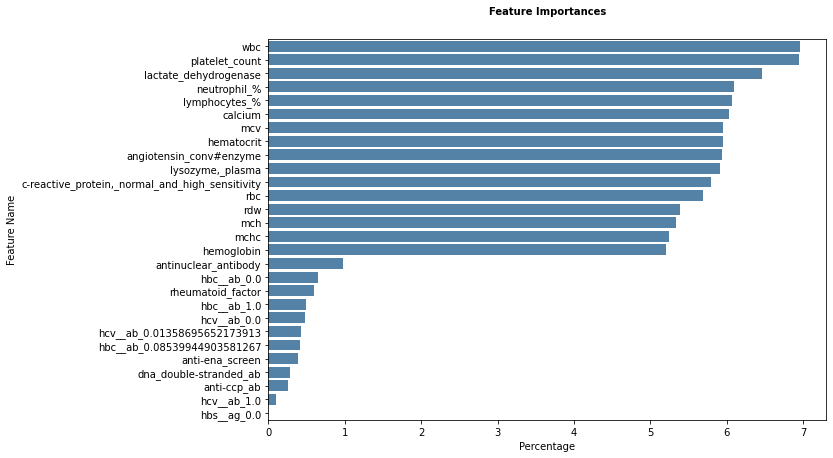

In [20]:
ran_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## KNN
### Complete positive data

Score: 0.25956328507558013
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 35, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

    anterior       0.29      0.23      0.26        56
intermediate       0.15      0.14      0.14        44
  panuveitis       0.33      0.31      0.32        55
   posterior       0.27      0.36      0.31        61

    accuracy                           0.27       216
   macro avg       0.26      0.26      0.26       216
weighted avg       0.27      0.27      0.27       216

Standarddeviation Score: 0.0218709563110985


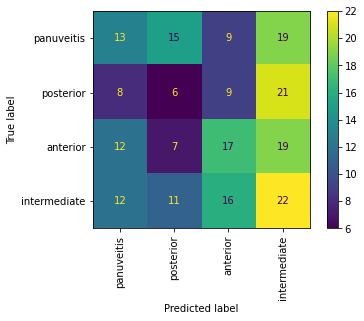

In [21]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_jobs=-1)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('knn', knn)
    ])

    # hyperparameterspace
    parameters = {
        'knn__n_neighbors':np.arange(5,100,10),
        'knn__weights':['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute']
    }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

knn_model(X_train, X_test, y_train, y_test)

### Male positive data 

Score: 0.26862041467304626
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 15, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

    anterior       0.12      0.10      0.11        20
intermediate       0.32      0.37      0.34        19
  panuveitis       0.28      0.33      0.30        24
   posterior       0.35      0.27      0.31        22

    accuracy                           0.27        85
   macro avg       0.27      0.27      0.26        85
weighted avg       0.27      0.27      0.27        85

Standarddeviation Score: 0.03319443324039153


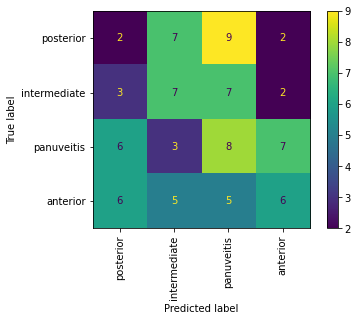

In [22]:
knn_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.3553494623655914
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 55, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

    anterior       0.33      0.42      0.37        36
intermediate       0.20      0.08      0.11        25
  panuveitis       0.47      0.26      0.33        31
   posterior       0.45      0.67      0.54        39

    accuracy                           0.39       131
   macro avg       0.36      0.36      0.34       131
weighted avg       0.37      0.39      0.36       131

Standarddeviation Score: 0.028232266718521436


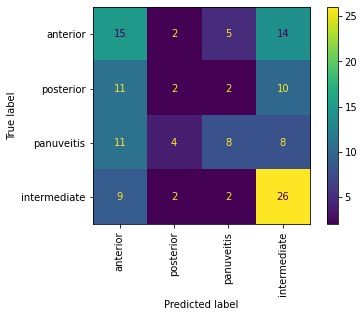

In [23]:
knn_model(X_train_f, X_test_f, y_train_f, y_test_f)

## SVM
### Complete positive data

Score: 0.2542101341281669
Best Parameters:
{'svc__C': 2.6, 'svc__class_weight': None, 'svc__degree': 3, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

    anterior       0.29      0.25      0.27        56
intermediate       0.22      0.25      0.23        44
  panuveitis       0.25      0.25      0.25        55
   posterior       0.26      0.26      0.26        61

    accuracy                           0.25       216
   macro avg       0.25      0.25      0.25       216
weighted avg       0.26      0.25      0.26       216

Standarddeviation Score: 0.026285769848885258


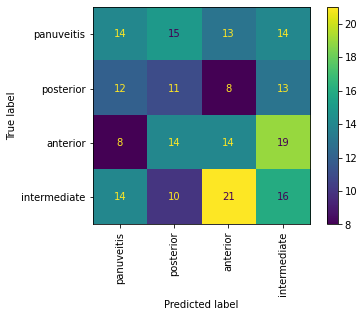

In [24]:
from sklearn.svm import SVC

def svc_model(X_train, X_test, y_train, y_test):
    svc = SVC(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('svc', svc)
    ])

    # hyperparameterspace
    parameters = {'svc__C':np.arange(0.1,3,.5),
                  'svc__kernel':['linear','poly','rbf','sigmoid'],
                  'svc__degree':np.arange(3,10,2), # used only for kernel = poly
                  'svc__class_weight':['balanced', None]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

    
svc_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.28499800637958533
Best Parameters:
{'svc__C': 2.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

    anterior       0.27      0.20      0.23        20
intermediate       0.24      0.42      0.30        19
  panuveitis       0.39      0.29      0.33        24
   posterior       0.28      0.23      0.25        22

    accuracy                           0.28        85
   macro avg       0.29      0.28      0.28        85
weighted avg       0.30      0.28      0.28        85

Standarddeviation Score: 0.023447445107044898


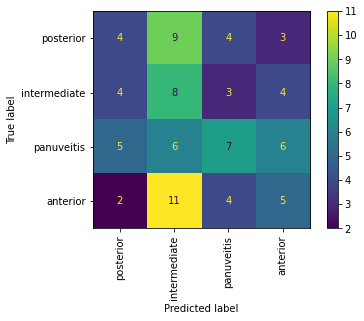

In [25]:
svc_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.29822511717673006
Best Parameters:
{'svc__C': 0.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'sigmoid'}
              precision    recall  f1-score   support

    anterior       0.32      0.31      0.31        36
intermediate       0.16      0.20      0.18        25
  panuveitis       0.26      0.23      0.24        31
   posterior       0.46      0.46      0.46        39

    accuracy                           0.31       131
   macro avg       0.30      0.30      0.30       131
weighted avg       0.32      0.31      0.31       131

Standarddeviation Score: 0.03802203342008547


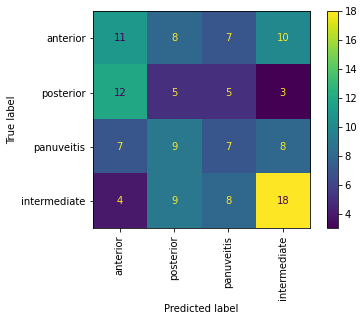

In [26]:
svc_model(X_train_f, X_test_f, y_train_f, y_test_f)

## MLP Classifier
### Complete positve data

Score: 0.26605413029593356
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
              precision    recall  f1-score   support

    anterior       0.21      0.16      0.18        56
intermediate       0.18      0.20      0.19        44
  panuveitis       0.28      0.27      0.28        55
   posterior       0.37      0.43      0.39        61

    accuracy                           0.27       216
   macro avg       0.26      0.27      0.26       216
weighted avg       0.27      0.27      0.27       216

Standarddeviation Score: 0.013823282063570563


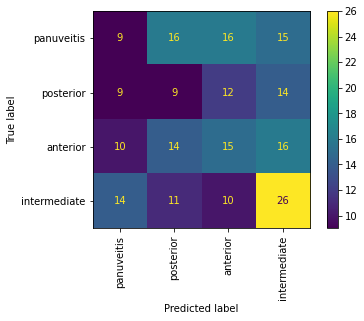

In [27]:
from sklearn.neural_network import MLPClassifier

def mlp_model(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('mlp', mlp)
    ])

    # hyperparameterspace
    parameters = {'mlp__hidden_layer_sizes':[(5,4),(5,5,4),(15,10),(20,20,10)]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

    
mlp_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.26371610845295057
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
              precision    recall  f1-score   support

    anterior       0.25      0.20      0.22        20
intermediate       0.17      0.16      0.16        19
  panuveitis       0.29      0.33      0.31        24
   posterior       0.35      0.36      0.36        22

    accuracy                           0.27        85
   macro avg       0.26      0.26      0.26        85
weighted avg       0.27      0.27      0.27        85

Standarddeviation Score: 0.04163911229046712


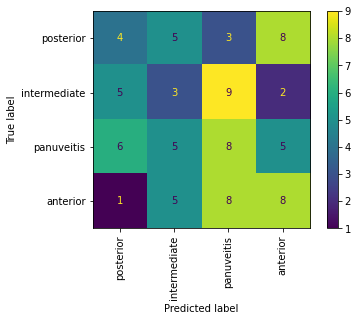

In [28]:
mlp_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.2896264130135098
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
              precision    recall  f1-score   support

    anterior       0.34      0.28      0.31        36
intermediate       0.19      0.20      0.19        25
  panuveitis       0.30      0.19      0.24        31
   posterior       0.35      0.49      0.40        39

    accuracy                           0.31       131
   macro avg       0.29      0.29      0.28       131
weighted avg       0.30      0.31      0.30       131

Standarddeviation Score: 0.012889270403776108


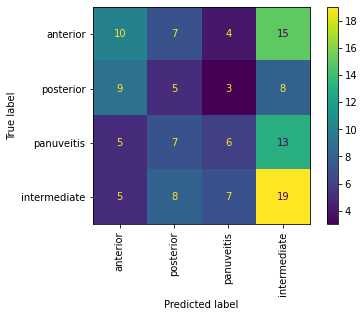

In [29]:
mlp_model(X_train_f, X_test_f, y_train_f, y_test_f)

## XGBoost
### Complete positve data

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   20.3s finished


Score: 0.3184519374068554
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 2, 'xgb__n_estimators': 10}
              precision    recall  f1-score   support

    anterior       0.37      0.38      0.37        56
intermediate       0.30      0.14      0.19        44
  panuveitis       0.34      0.42      0.38        55
   posterior       0.29      0.34      0.32        61

    accuracy                           0.33       216
   macro avg       0.33      0.32      0.31       216
weighted avg       0.33      0.33      0.32       216

Standarddeviation Score: 0.009146319828478732


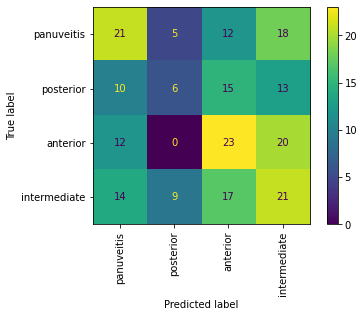

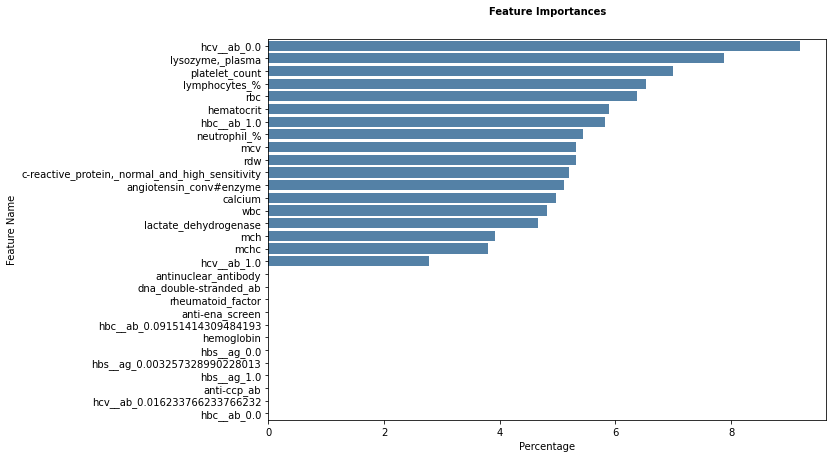

In [30]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)


xgb_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   16.0s finished


Score: 0.300737639553429
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 2, 'xgb__n_estimators': 10}
              precision    recall  f1-score   support

    anterior       0.33      0.25      0.29        20
intermediate       0.20      0.21      0.21        19
  panuveitis       0.28      0.33      0.30        24
   posterior       0.43      0.41      0.42        22

    accuracy                           0.31        85
   macro avg       0.31      0.30      0.30        85
weighted avg       0.31      0.31      0.31        85

Standarddeviation Score: 0.026168705615236286


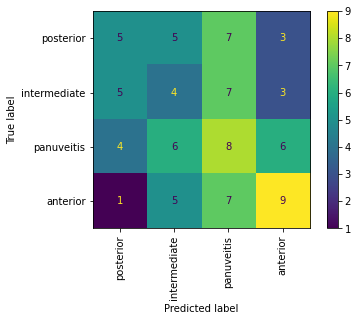

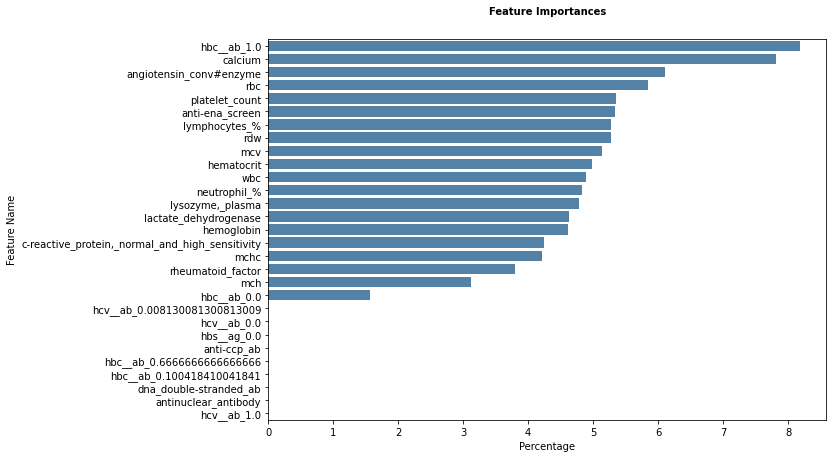

In [31]:
xgb_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   25.0s finished


Score: 0.24708712434518887
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 5, 'xgb__n_estimators': 15}
              precision    recall  f1-score   support

    anterior       0.27      0.28      0.27        36
intermediate       0.16      0.12      0.14        25
  panuveitis       0.19      0.13      0.15        31
   posterior       0.33      0.46      0.39        39

    accuracy                           0.27       131
   macro avg       0.24      0.25      0.24       131
weighted avg       0.25      0.27      0.25       131

Standarddeviation Score: 0.034327576496773635


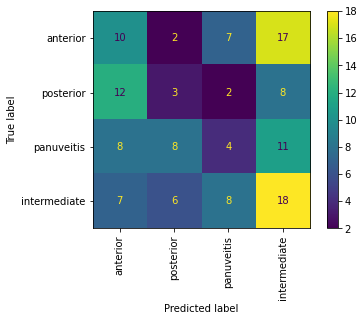

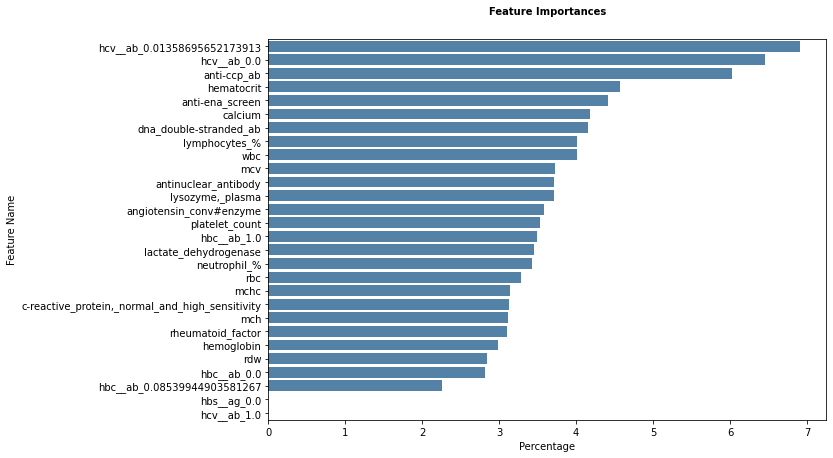

In [32]:
xgb_model(X_train_f, X_test_f, y_train_f, y_test_f)

## AdaBoost
### Complete positve data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:  6.5min finished


Score: 0.2443873749201618
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'gini', 'ada__base_estimator__max_depth': 18, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 50}
              precision    recall  f1-score   support

    anterior       0.23      0.21      0.22        56
intermediate       0.26      0.25      0.25        44
  panuveitis       0.20      0.22      0.21        55
   posterior       0.30      0.30      0.30        61

    accuracy                           0.25       216
   macro avg       0.25      0.24      0.24       216
weighted avg       0.25      0.25      0.25       216

Standarddeviation Score: 0.010540608813628496


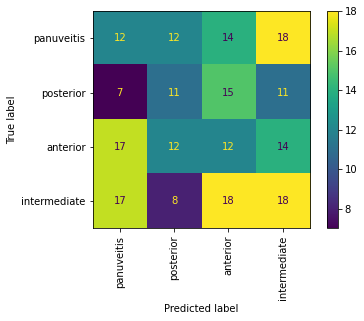

In [33]:
from sklearn.ensemble import AdaBoostClassifier

def ada_model(X_train, X_test, y_train, y_test):
    base_estimator = DecisionTreeClassifier(random_state=RANDOM)

    ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RANDOM)

    pipeline = Pipeline(steps=[
                ('prep', USE_IMPUTER),
                ('ada', ada)
            ])

    params = {'ada__base_estimator__criterion':['gini','entropy'],
            'ada__base_estimator__splitter' :['best','random'],
            'ada__base_estimator__max_depth':np.arange(2,20,2),
            'ada__base_estimator__min_samples_split':[int(i) for i in np.arange(2,20,10)],
            'ada__base_estimator__random_state':[RANDOM],
            'ada__base_estimator__class_weight':['balanced', None],
            'ada__n_estimators':[10,25,50]}

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    #plot_featureimportance(bv.best_estimator_)

    
ada_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:  3.9min finished


Score: 0.3120015948963317
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'gini', 'ada__base_estimator__max_depth': 4, 'ada__base_estimator__min_samples_split': 2, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 25}
              precision    recall  f1-score   support

    anterior       0.29      0.25      0.27        20
intermediate       0.24      0.26      0.25        19
  panuveitis       0.37      0.42      0.39        24
   posterior       0.35      0.32      0.33        22

    accuracy                           0.32        85
   macro avg       0.31      0.31      0.31        85
weighted avg       0.32      0.32      0.32        85

Standarddeviation Score: 0.019547838468938795


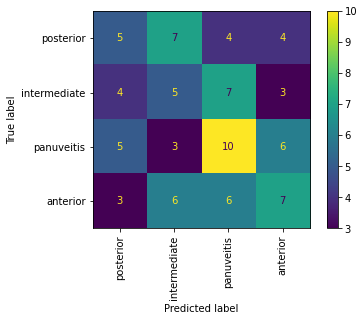

In [34]:
ada_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:  4.6min finished


Score: 0.3330452164323132
Best Parameters:
{'ada__base_estimator__class_weight': None, 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 18, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 50}
              precision    recall  f1-score   support

    anterior       0.40      0.39      0.39        36
intermediate       0.25      0.16      0.20        25
  panuveitis       0.30      0.19      0.24        31
   posterior       0.38      0.59      0.46        39

    accuracy                           0.36       131
   macro avg       0.33      0.33      0.32       131
weighted avg       0.34      0.36      0.34       131

Standarddeviation Score: 0.040553123283738494


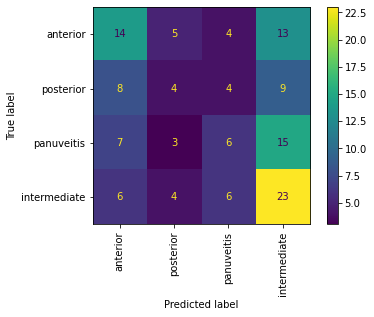

In [35]:
ada_model(X_train_f, X_test_f, y_train_f, y_test_f)

# Binary classification
In this section we try to predict the location of an inflammation of uveitis positive patients. For this we remove records of non uveitis patients.
These models can be used as a comparison for the mulitclass classification (see chapter above)

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [36]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'binary',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

gender                loc  calcium  lactate_dehydrogenase  \
0    Male   anterior_segment     2.27                    184   
1  Female  posterior_segment     2.32                    209   
2  Female  posterior_segment     2.44                    194   
3  Female   anterior_segment     2.45                    156   
4  Female   anterior_segment     2.28                    175   

   c-reactive_protein,_normal_and_high_sensitivity   wbc   rbc  hemoglobin  \
0                                            1.830  6.91  4.97        14.6   
1                                            0.150  4.24  4.22        11.0   
2                                            0.137  6.38  4.31        13.6   
3                                            3.500  5.24  4.82        14.6   
4                                            1.000  8.31  4.72        14.0   

   hematocrit   mcv  ...  lysozyme,_plasma  anti-ccp_ab  anti-ena_screen  \
0        41.4  83.3  ...               3.0          0.0              0.0   
1        36.0  85.3  ...               NaN          0.0              0.0   
2        38.7  89.8  ...               4.8          0.0              0.0   
3        43.6  90.5  ...               NaN          0.0              0.0   
4        40.7  86.2  ...               4.5          0.0              0.0   

   antinuclear_antibody  dna_double-stranded_ab  rheumatoid_factor  hbc__ab  \
0                   0.0                     0.0                  0        0   
1                   0.0                     0.0                  0        0   
2                   0.0                     0.0                  0        0   
3                   0.0                     0.0                  0        0   
4                   0.0                     1.0                  0        0   

   hbs__ag  hcv__ab  uveitis  
0        0        0    False  
1        0        0     True  
2        0        0     True  
3        0        0     True  
4        0        0     True  

[5 rows x 27 columns]

### Split into uveitis and not_uveitis data

In [37]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

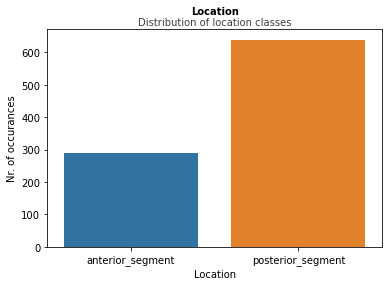

In [38]:
df_uv_pos_clean = df_uv_pos.dropna(subset=['loc']) # drop records with missing location data (3)


g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes','Location','Nr. of occurances')

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the loc (Location)-Feature. 
The target feature contains 3 missing values. We initially drop these records.

In [39]:
# train_test_split
X = df_uv_pos_clean.drop(columns=['loc','uveitis','gender'])
y = df_uv_pos_clean['loc']

X_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male'].drop(columns=['loc','uveitis','gender'])
X_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female'].drop(columns=['loc','uveitis','gender'])
y_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male']['loc']
y_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female']['loc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=RANDOM, stratify = y_m)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25, random_state=RANDOM, stratify = y_f)

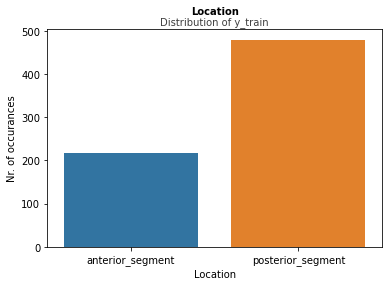

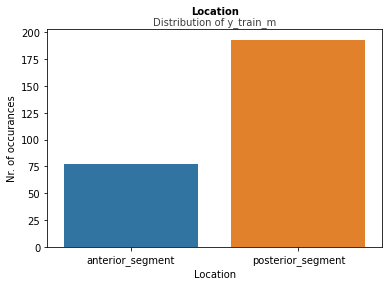

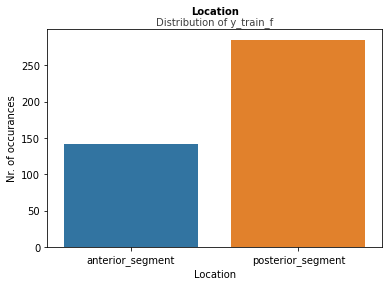

In [40]:
g = sns.countplot(x=y_train)
helpers.plot_wrapper(g, 'Location','Distribution of y_train','Location','Nr. of occurances')
g = sns.countplot(x=y_train_m)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_m','Location','Nr. of occurances')
g = sns.countplot(x=y_train_f)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_f','Location','Nr. of occurances')

#### Imputation and Encoding

In [41]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=False)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_onehot_knn # imputer_encoder_onehot yields best results so far 

## 3-Dimensional Data Representation

In [42]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train.values,
                   title="PCA representation of uveitits positive training data", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 40.0 %


In [43]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_m)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_m.values,
                   title="PCA representation of uveitits positive training data (male only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.09 %


In [44]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_f)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_f.values,
                   title="PCA representation of uveitits positive training data (female only)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.32 %


## Baseline Model
This model acts as our basline. This model takes in the prior probability of a class occuring in the trainingset, and recommends blindly based on these probabilites. 
### Complete positive data

In [45]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train, y_train)
print(f'Score Dummy Classifier: {SCORE(y_test, pipeline.predict(X_test))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.48818493150684933
Class probabilites: [0.31276901 0.68723099]


### Male positive data

In [46]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_m, y_train_m)
print(f'Score Dummy Classifier: {SCORE(y_test_m, pipeline.predict(X_test_m))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.5153846153846153
Class probabilites: [0.28518519 0.71481481]


### Female positive data

In [47]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_f, y_train_f)
print(f'Score Dummy Classifier: {SCORE(y_test_f, pipeline.predict(X_test_f))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.5671542553191489
Class probabilites: [0.33098592 0.66901408]


## Decision Tree

### Complete positive data

Score: 0.5403253424657535
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'entropy', 'tree__max_depth': 16, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'random'}
                   precision    recall  f1-score   support

 anterior_segment       0.35      0.49      0.41        73
posterior_segment       0.72      0.59      0.65       160

         accuracy                           0.56       233
        macro avg       0.54      0.54      0.53       233
     weighted avg       0.60      0.56      0.57       233

Standarddeviation Score: 0.03153753416526446


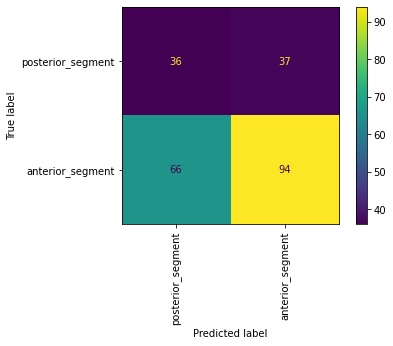

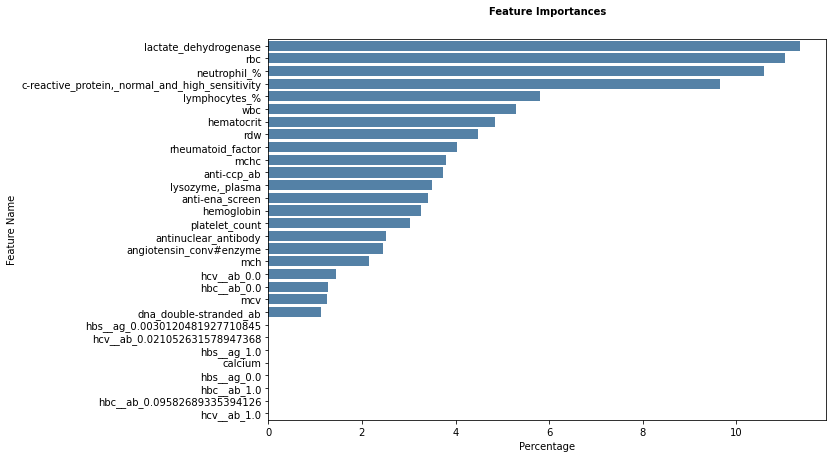

In [48]:
# supress warnings of estimator fit failed
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def dec_tree(X_train, X_test, y_train, y_test):
    dectree = DecisionTreeClassifier(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', dectree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__criterion':['gini','entropy'],
        'tree__splitter' :['best','random'],
        'tree__max_depth':np.arange(2,20,2),
        'tree__min_samples_split':[int(i) for i in np.arange(2,20,10)],
        'tree__random_state':[RANDOM],
        'tree__class_weight':['balanced', None] # balanced = inverse proportional importance per class
    }

    # grid search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

    plot_featureimportance(bv.best_estimator_)

dec_tree(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.6153846153846154
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 12, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'random'}
                   precision    recall  f1-score   support

 anterior_segment       0.44      0.46      0.45        26
posterior_segment       0.78      0.77      0.78        65

         accuracy                           0.68        91
        macro avg       0.61      0.62      0.61        91
     weighted avg       0.69      0.68      0.68        91

Standarddeviation Score: 0.010913690978046741


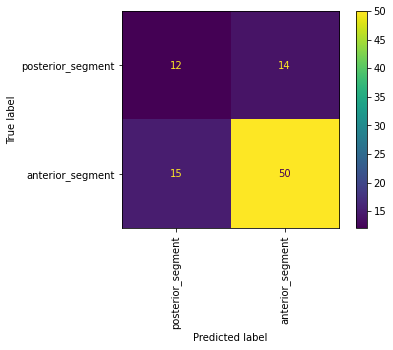

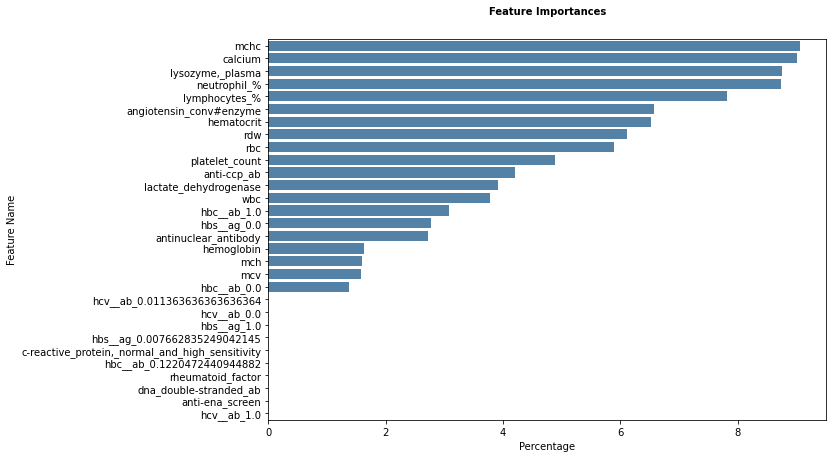

In [49]:
dec_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5089760638297872
Best Parameters:
{'tree__class_weight': None, 'tree__criterion': 'entropy', 'tree__max_depth': 18, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'random'}
                   precision    recall  f1-score   support

 anterior_segment       0.34      0.36      0.35        47
posterior_segment       0.68      0.66      0.67        96

         accuracy                           0.56       143
        macro avg       0.51      0.51      0.51       143
     weighted avg       0.57      0.56      0.56       143

Standarddeviation Score: 0.04897122146223396


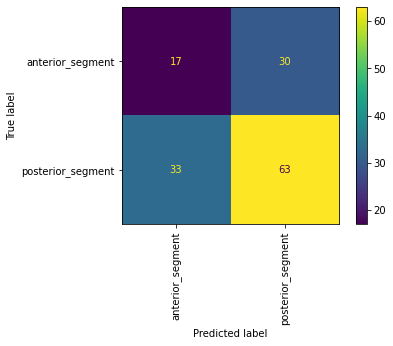

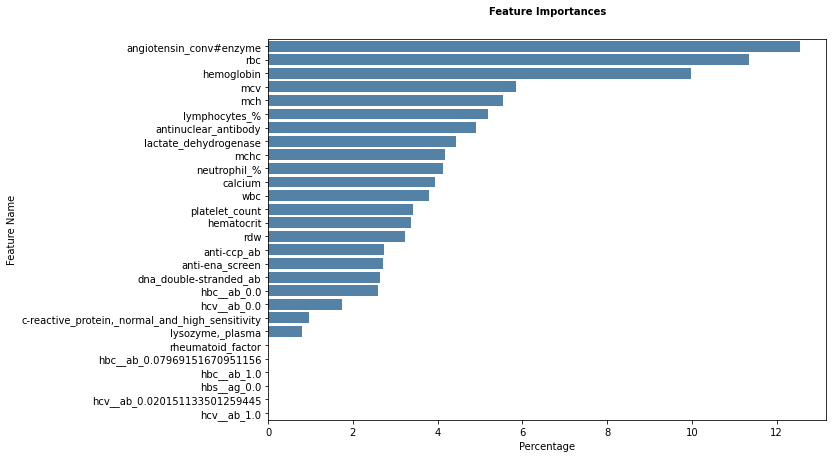

In [50]:
dec_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## Random Forest
### Complete positive data

Score: 0.4867722602739726
Best Parameters:
{'tree__max_features': 'sqrt', 'tree__n_estimators': 100, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.24      0.05      0.09        73
posterior_segment       0.68      0.92      0.78       160

         accuracy                           0.65       233
        macro avg       0.46      0.49      0.44       233
     weighted avg       0.54      0.65      0.56       233

Standarddeviation Score: 0.013842940565996624


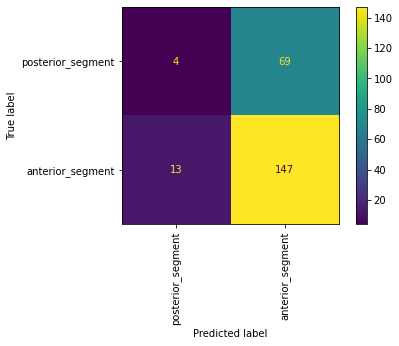

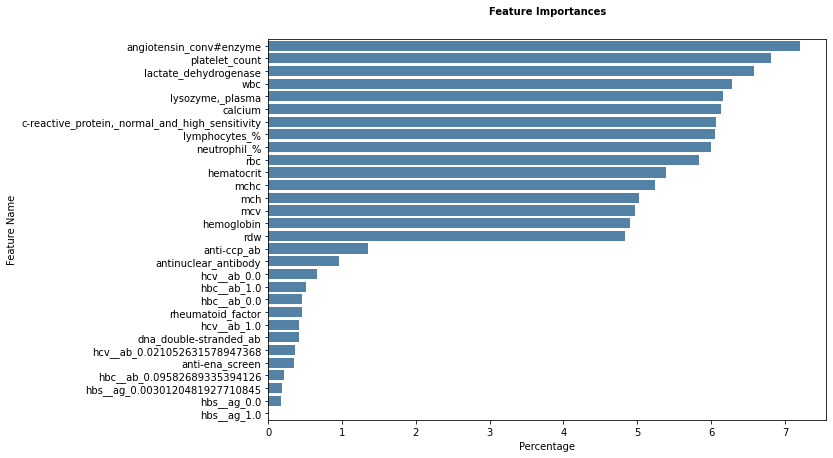

In [51]:
from sklearn.ensemble import RandomForestClassifier

def ran_tree(X_train, X_test, y_train, y_test):
    rantree = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', rantree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__n_estimators':[100,1000],
        'tree__max_features':['log2', 'sqrt', 'auto'],
        'tree__oob_score':[True,False]
    }

    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv.best_estimator_, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)


    
ran_tree(X_train, X_test, y_train, y_test)

In [52]:
# helpers.plot_validation_curve(bv.best_estimator_.fit(X_train, y_train), X_test, y_test, 'tree__n_estimators',np.arange(10,100,10), scorer)

### Male positive data

Score: 0.49230769230769234
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 100, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.25      0.08      0.12        26
posterior_segment       0.71      0.91      0.80        65

         accuracy                           0.67        91
        macro avg       0.48      0.49      0.46        91
     weighted avg       0.58      0.67      0.60        91

Standarddeviation Score: 0.0127865184324843


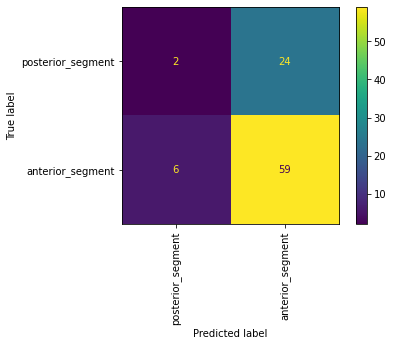

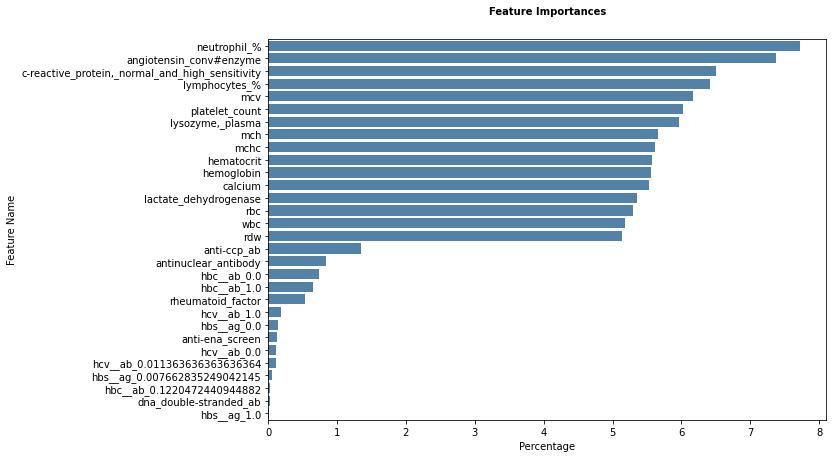

In [53]:
ran_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5382313829787234
Best Parameters:
{'tree__max_features': 'sqrt', 'tree__n_estimators': 1000, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.47      0.17      0.25        47
posterior_segment       0.69      0.91      0.78        96

         accuracy                           0.66       143
        macro avg       0.58      0.54      0.52       143
     weighted avg       0.62      0.66      0.61       143

Standarddeviation Score: 0.026425451675234704


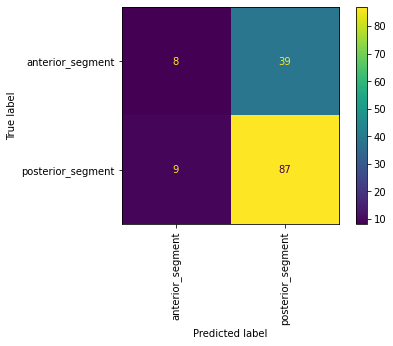

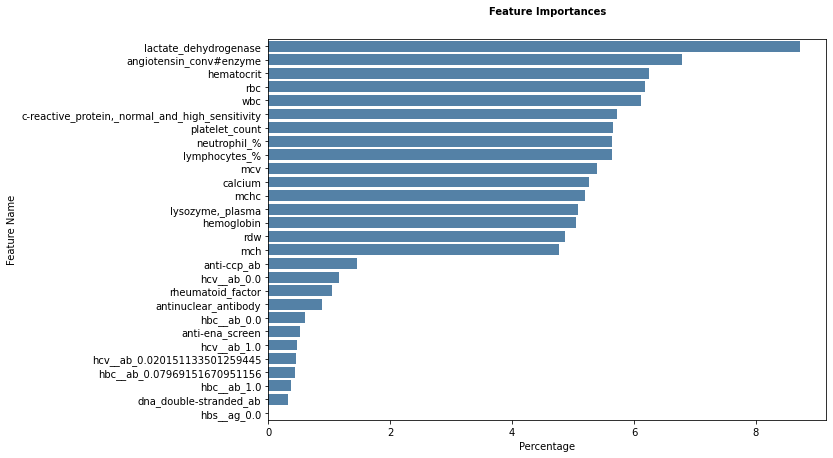

In [54]:
ran_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## KNN
### Complete positive data

Score: 0.5329195205479452
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.53      0.11      0.18        73
posterior_segment       0.70      0.96      0.81       160

         accuracy                           0.69       233
        macro avg       0.62      0.53      0.50       233
     weighted avg       0.65      0.69      0.61       233

Standarddeviation Score: 0.010078534601277465


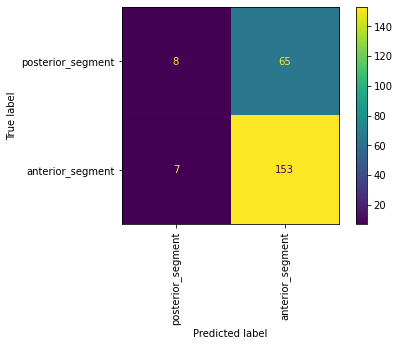

In [55]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_jobs=-1)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('knn', knn)
    ])

    # hyperparameterspace
    parameters = {
        'knn__n_neighbors':np.arange(5,100,10),
        'knn__weights':['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute']
    }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
knn_model(X_train, X_test, y_train, y_test)

### Male positive data 

Score: 0.5307692307692308
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.35      0.23      0.28        26
posterior_segment       0.73      0.83      0.78        65

         accuracy                           0.66        91
        macro avg       0.54      0.53      0.53        91
     weighted avg       0.62      0.66      0.63        91

Standarddeviation Score: 0.012732449956191348


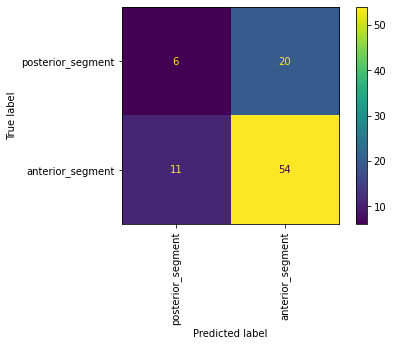

In [56]:
knn_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5234929078014184
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.38      0.26      0.30        47
posterior_segment       0.68      0.79      0.73        96

         accuracy                           0.62       143
        macro avg       0.53      0.52      0.52       143
     weighted avg       0.58      0.62      0.59       143

Standarddeviation Score: 0.02610925494179384


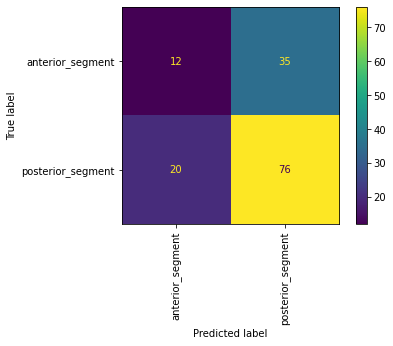

In [57]:
knn_model(X_train_f, X_test_f, y_train_f, y_test_f)

## SVM
### Complete positive data

Score: 0.4986301369863013
Best Parameters:
{'svc__C': 1.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
                   precision    recall  f1-score   support

 anterior_segment       0.31      0.40      0.35        73
posterior_segment       0.69      0.60      0.64       160

         accuracy                           0.54       233
        macro avg       0.50      0.50      0.49       233
     weighted avg       0.57      0.54      0.55       233

Standarddeviation Score: 0.017979673297801882


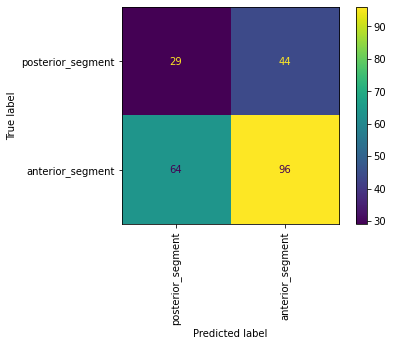

In [58]:
from sklearn.svm import SVC

def svc_model(X_train, X_test, y_train, y_test):
    svc = SVC(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('svc', svc)
    ])

    # hyperparameterspace
    parameters = {'svc__C':np.arange(0.1,3,.5),
                  'svc__kernel':['linear','poly','rbf','sigmoid'],
                  'svc__degree':np.arange(3,10,2), # used only for kernel = poly
                  'svc__class_weight':['balanced', None]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
svc_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.5461538461538462
Best Parameters:
{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'linear'}
                   precision    recall  f1-score   support

 anterior_segment       0.33      0.54      0.41        26
posterior_segment       0.75      0.55      0.64        65

         accuracy                           0.55        91
        macro avg       0.54      0.55      0.52        91
     weighted avg       0.63      0.55      0.57        91

Standarddeviation Score: 0.02158782630407348


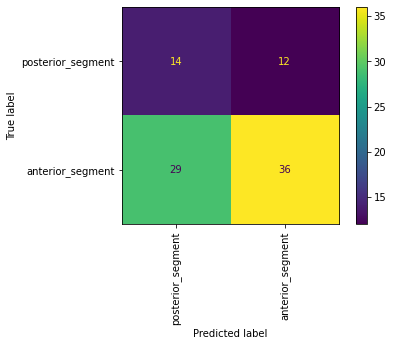

In [59]:
svc_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5306959219858156
Best Parameters:
{'svc__C': 2.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
                   precision    recall  f1-score   support

 anterior_segment       0.36      0.45      0.40        47
posterior_segment       0.69      0.61      0.65        96

         accuracy                           0.56       143
        macro avg       0.53      0.53      0.53       143
     weighted avg       0.58      0.56      0.57       143

Standarddeviation Score: 0.02181444954397037


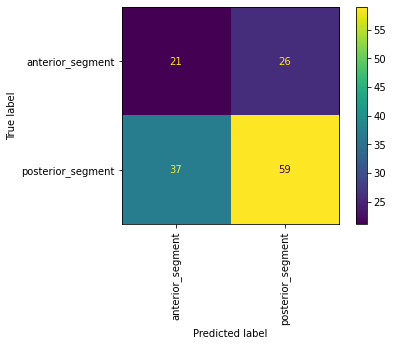

In [60]:
svc_model(X_train_f, X_test_f, y_train_f, y_test_f)

## MLP Classifier
### Complete positve data

Score: 0.4982876712328767
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.31      0.25      0.27        73
posterior_segment       0.69      0.75      0.72       160

         accuracy                           0.59       233
        macro avg       0.50      0.50      0.50       233
     weighted avg       0.57      0.59      0.58       233

Standarddeviation Score: 0.02928155555666732


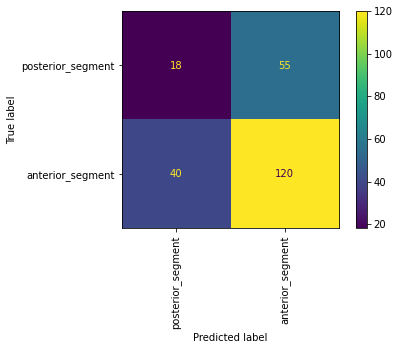

In [61]:
from sklearn.neural_network import MLPClassifier

def mlp_model(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('mlp', mlp)
    ])

    # hyperparameterspace
    parameters = {'mlp__hidden_layer_sizes':[(5,4),(5,5,4),(15,10),(20,20,10)]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    

    
mlp_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.5346153846153846
Best Parameters:
{'mlp__hidden_layer_sizes': (5, 4)}
                   precision    recall  f1-score   support

 anterior_segment       0.50      0.12      0.19        26
posterior_segment       0.73      0.95      0.83        65

         accuracy                           0.71        91
        macro avg       0.61      0.53      0.51        91
     weighted avg       0.66      0.71      0.64        91

Standarddeviation Score: 0.01599873943993703


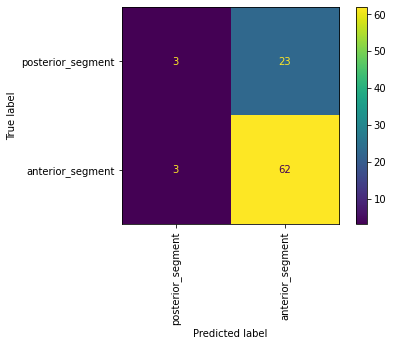

In [62]:
mlp_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5562943262411347
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.40      0.40      0.40        47
posterior_segment       0.71      0.71      0.71        96

         accuracy                           0.61       143
        macro avg       0.56      0.56      0.56       143
     weighted avg       0.61      0.61      0.61       143

Standarddeviation Score: 0.01965497348199833


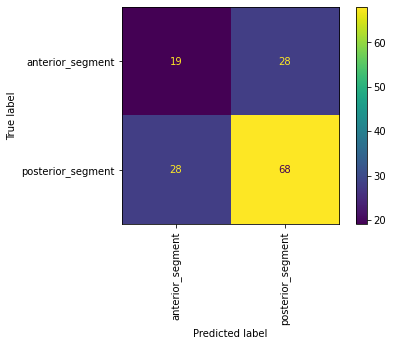

In [63]:
mlp_model(X_train_f, X_test_f, y_train_f, y_test_f)

## XGBoost
### Complete positve data

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    9.1s finished


Score: 0.5408390410958904
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 7, 'xgb__n_estimators': 15}
                   precision    recall  f1-score   support

 anterior_segment       0.42      0.22      0.29        73
posterior_segment       0.71      0.86      0.78       160

         accuracy                           0.66       233
        macro avg       0.56      0.54      0.53       233
     weighted avg       0.62      0.66      0.62       233

Standarddeviation Score: 0.011843268626304543


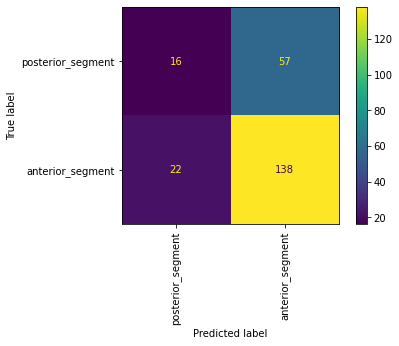

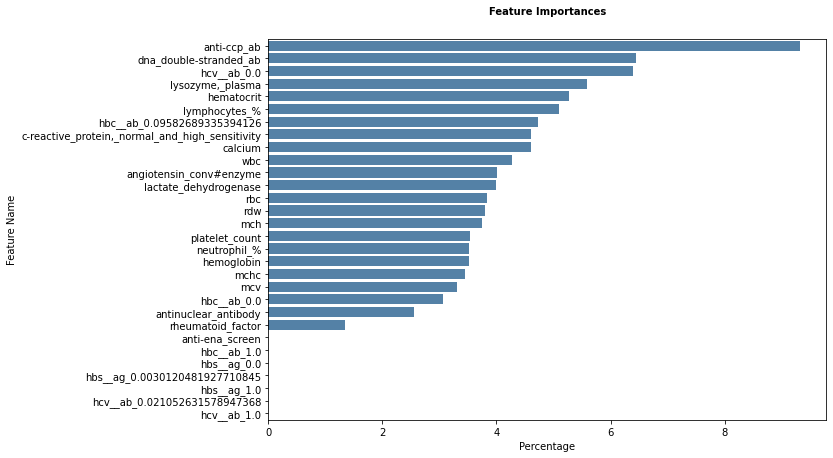

In [64]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

xgb_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    7.2s finished


Score: 0.5692307692307692
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 5, 'xgb__n_estimators': 20}
                   precision    recall  f1-score   support

 anterior_segment       0.50      0.23      0.32        26
posterior_segment       0.75      0.91      0.82        65

         accuracy                           0.71        91
        macro avg       0.62      0.57      0.57        91
     weighted avg       0.68      0.71      0.68        91

Standarddeviation Score: 0.02933633553591637


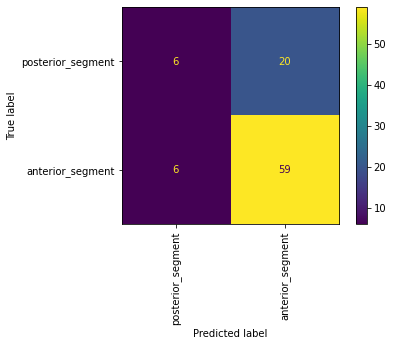

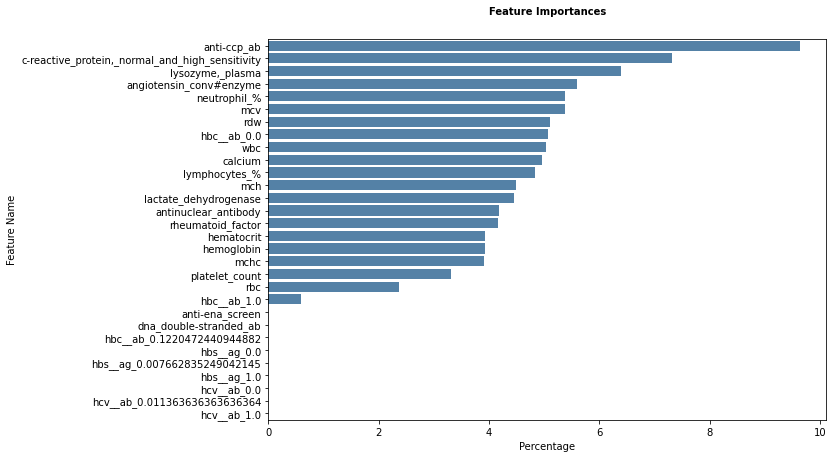

In [65]:
xgb_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    8.5s finished


Score: 0.5601728723404256
Best Parameters:
{'xgb__colsample_bytree': 0.3, 'xgb__max_depth': 5, 'xgb__n_estimators': 20}
                   precision    recall  f1-score   support

 anterior_segment       0.46      0.28      0.35        47
posterior_segment       0.70      0.84      0.77        96

         accuracy                           0.66       143
        macro avg       0.58      0.56      0.56       143
     weighted avg       0.63      0.66      0.63       143

Standarddeviation Score: 0.006696699168842856


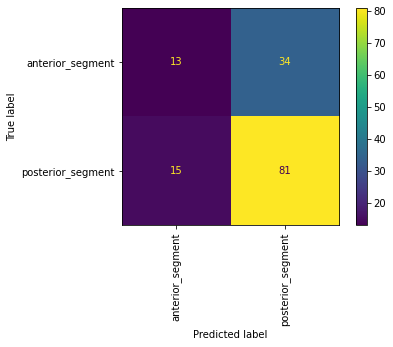

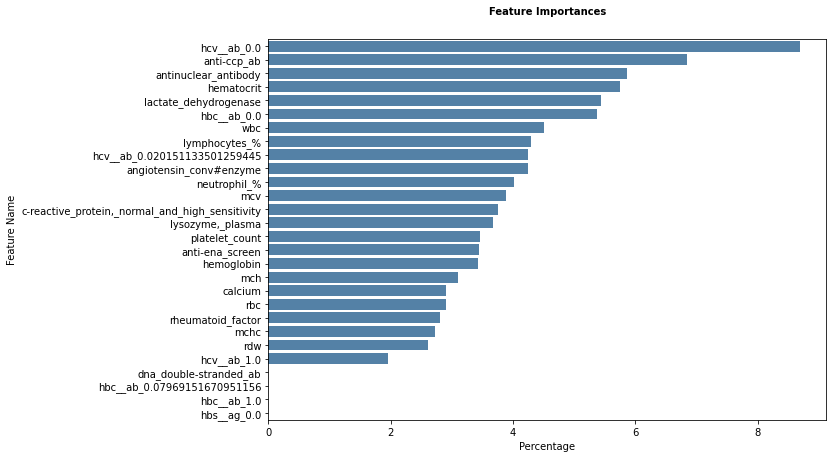

In [66]:
xgb_model(X_train_f, X_test_f, y_train_f, y_test_f)

## AdaBoost
### Complete positve data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:  6.3min finished


Score: 0.4991438356164384
Best Parameters:
{'ada__base_estimator__class_weight': None, 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 12, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 25}
                   precision    recall  f1-score   support

 anterior_segment       0.31      0.12      0.18        73
posterior_segment       0.69      0.88      0.77       160

         accuracy                           0.64       233
        macro avg       0.50      0.50      0.47       233
     weighted avg       0.57      0.64      0.58       233

Standarddeviation Score: 0.010005012941634705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py:590: RuntimeWarning:

invalid value encountered in true_divide



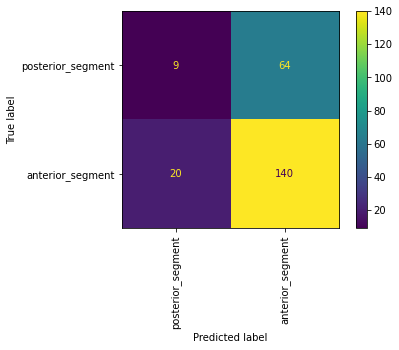

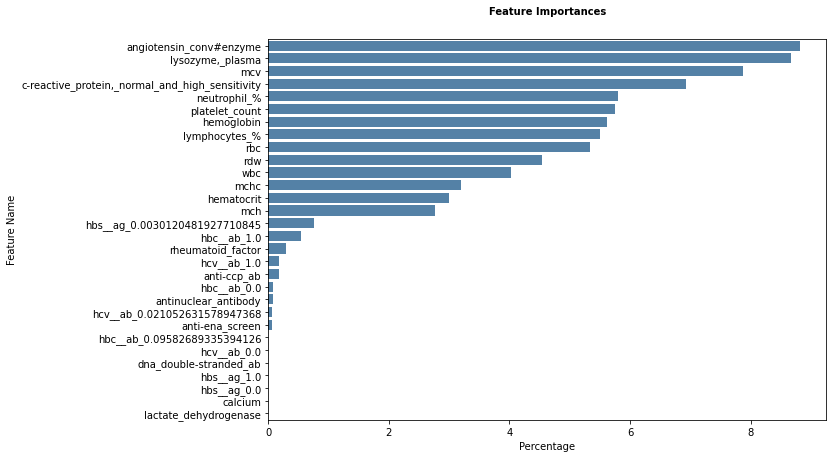

In [67]:
from sklearn.ensemble import AdaBoostClassifier

def ada_model(X_train, X_test, y_train, y_test):
    base_estimator = DecisionTreeClassifier(random_state=RANDOM)

    ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RANDOM)

    pipeline = Pipeline(steps=[
                ('prep', USE_IMPUTER),
                ('ada', ada)
            ])

    params = {'ada__base_estimator__criterion':['gini','entropy'],
            'ada__base_estimator__splitter' :['best','random'],
            'ada__base_estimator__max_depth':np.arange(2,20,2),
            'ada__base_estimator__min_samples_split':[int(i) for i in np.arange(2,20,10)],
            'ada__base_estimator__random_state':[RANDOM],
            'ada__base_estimator__class_weight':['balanced', None],
            'ada__n_estimators':[10,25,50]}

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
    plot_featureimportance(bv.best_estimator_)

ada_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:  2.9min finished


Score: 0.6461538461538462
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 2, 'ada__base_estimator__min_samples_split': 2, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 25}
                   precision    recall  f1-score   support

 anterior_segment       0.52      0.46      0.49        26
posterior_segment       0.79      0.83      0.81        65

         accuracy                           0.73        91
        macro avg       0.66      0.65      0.65        91
     weighted avg       0.72      0.73      0.72        91

Standarddeviation Score: 0.048649817142983116


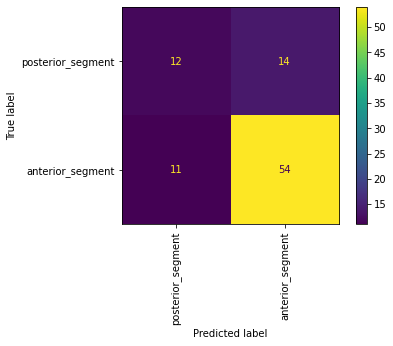

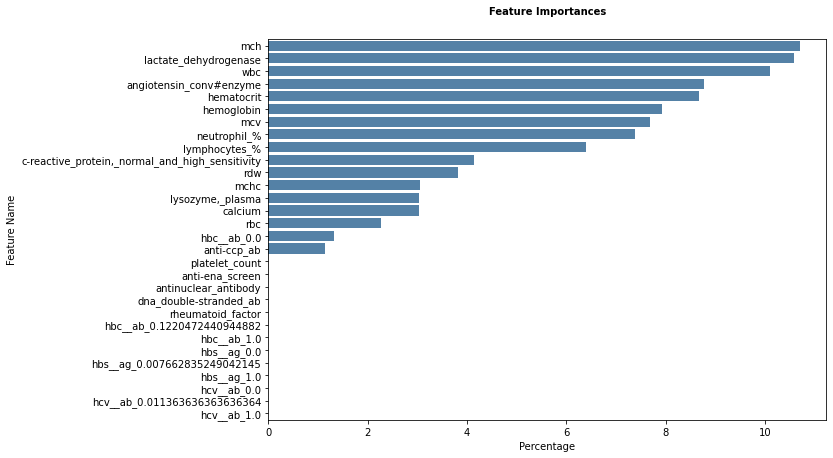

In [68]:
ada_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:  3.0min finished


Score: 0.49922429078014185
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 2, 'ada__base_estimator__min_samples_split': 2, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 10}
                   precision    recall  f1-score   support

 anterior_segment       0.33      0.43      0.37        47
posterior_segment       0.67      0.57      0.62        96

         accuracy                           0.52       143
        macro avg       0.50      0.50      0.49       143
     weighted avg       0.56      0.52      0.54       143

Standarddeviation Score: 0.05045157048317823


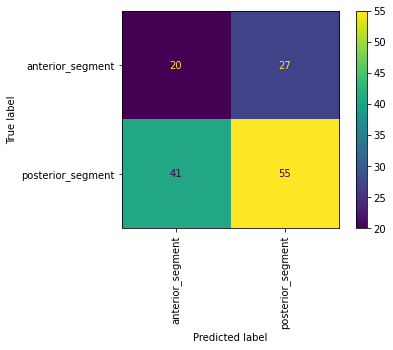

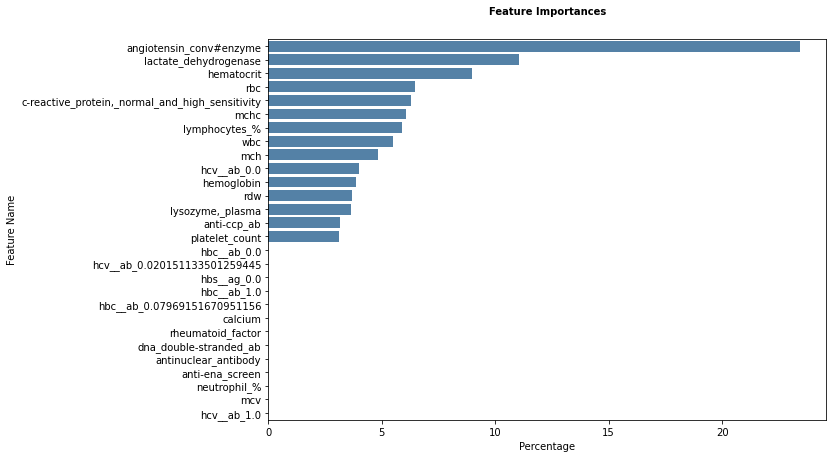

In [69]:
ada_model(X_train_f, X_test_f, y_train_f, y_test_f)

# One vs. All Location Prediction
In this section we try to identify importent lab tests for a location. For this train a model for every single location and mask every other location as "other". For easy interpretability and feature extraction we restrain ourselfs to tree based algorithmns.

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [70]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

gender           loc  calcium  lactate_dehydrogenase  \
0    Male      anterior     2.27                    184   
1  Female  intermediate     2.32                    209   
2  Female    panuveitis     2.44                    194   
3  Female      anterior     2.45                    156   
4  Female      anterior     2.28                    175   

   c-reactive_protein,_normal_and_high_sensitivity   wbc   rbc  hemoglobin  \
0                                            1.830  6.91  4.97        14.6   
1                                            0.150  4.24  4.22        11.0   
2                                            0.137  6.38  4.31        13.6   
3                                            3.500  5.24  4.82        14.6   
4                                            1.000  8.31  4.72        14.0   

   hematocrit   mcv  ...  lysozyme,_plasma  anti-ccp_ab  anti-ena_screen  \
0        41.4  83.3  ...               3.0          0.0              0.0   
1        36.0  85.3  ...               NaN          0.0              0.0   
2        38.7  89.8  ...               4.8          0.0              0.0   
3        43.6  90.5  ...               NaN          0.0              0.0   
4        40.7  86.2  ...               4.5          0.0              0.0   

   antinuclear_antibody  dna_double-stranded_ab  rheumatoid_factor  hbc__ab  \
0                   0.0                     0.0                  0        0   
1                   0.0                     0.0                  0        0   
2                   0.0                     0.0                  0        0   
3                   0.0                     0.0                  0        0   
4                   0.0                     1.0                  0        0   

   hbs__ag  hcv__ab  uveitis  
0        0        0    False  
1        0        0     True  
2        0        0     True  
3        0        0     True  
4        0        0     True  

[5 rows x 27 columns]

### Split into uveitis and not_uveitis data

In [71]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

In [72]:
df_uv_pos.dropna(subset=['loc'], inplace=True)

In [73]:
def df_one_loc(df, i):
    df_one_vs_all = df.copy()
    df_one_vs_all['loc'] = np.where(df['loc'] != i, "other", df_uv_pos['loc'])
    return df_one_vs_all

df_pos_anterior = df_one_loc(df_uv_pos, 'anterior')
df_pos_intermediate = df_one_loc(df_uv_pos, 'intermediate')
df_pos_panuveitis = df_one_loc(df_uv_pos, 'panuveitis')
df_pos_posterior = df_one_loc(df_uv_pos, 'posterior')
df_pos_scleritis = df_one_loc(df_uv_pos, 'scleritis')

#### Train Test Split

In [74]:
def split_one_loc(df):
    X = df.drop(columns=['loc','uveitis','gender'])
    y = df['loc']
    return train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)

X_train_anterior, X_test_anterior, y_train_anterior, y_test_anterior = split_one_loc(df_pos_anterior)
X_train_intermediate, X_test_intermediate, y_train_intermediate, y_test_intermediate = split_one_loc(df_pos_intermediate)
X_train_panuveitis, X_test_panuveitis, y_train_panuveitis, y_test_panuveitis = split_one_loc(df_pos_panuveitis)
X_train_posterior, X_test_posterior, y_train_posterior, y_test_posterior = split_one_loc(df_pos_posterior)
X_train_scleritis, X_test_scleritis, y_train_scleritis, y_test_scleritis = split_one_loc(df_pos_scleritis)

In [75]:
X_train_anterior.hbc__ab.unique()

[0, 1, NaN]
Categories (2, int64): [0, 1]

#### Imputation and Encoding

In [76]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool', 'object']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=False)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_onehot_knn # imputer_encoder_onehot yields best results so far 

## 3-Dimensional Data Representation

In [77]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_anterior)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_anterior.values,
                   title="PCA representation of uveitits positive training data (Anterior vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.06 %


In [78]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_intermediate)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_intermediate.values,
                   title="PCA representation of uveitits positive training data (Intermediate vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.62 %


In [79]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_panuveitis)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_panuveitis.values,
                   title="PCA representation of uveitits positive training data (panuveitis vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.95 %


In [80]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_posterior)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_posterior.values,
                   title="PCA representation of uveitits positive training data (posterior vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.15 %


In [81]:
pca = PCA(n_components=3)
pipeline = Pipeline(steps=[('prep', USE_IMPUTER),('pca',pca)])
X_pca = pipeline.fit_transform(X_train_scleritis)
X_pca = pd.DataFrame(X_pca)
fig = px.scatter_3d(X_pca, x=0, y=1, z=2, color = y_train_scleritis.values,
                   title="PCA representation of uveitits positive training data (Anterior vs. all)", labels={"0":"PC1","1":"PC2","2":"PC3"})
fig.show()
print(f'Retained Variance: {round(sum(pipeline["pca"].explained_variance_ratio_)*100,2)} %')

Retained Variance: 39.85 %


## XGBoost

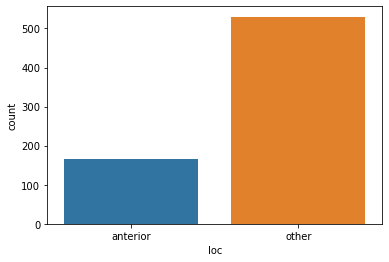

In [82]:
sns.countplot(x=y_train_anterior)

In [83]:
lab = LabelEncoder()
y_train_anterior_enc, y_test_anterior_enc = lab.fit_transform(y_train_anterior), lab.transform(y_test_anterior)
y_train_intermediate_enc, y_test_intermediate_enc = lab.fit_transform(y_train_intermediate), lab.transform(y_test_intermediate)
y_train_panuveitis_enc, y_test_panuveitis_enc = lab.fit_transform(y_train_panuveitis), lab.transform(y_test_panuveitis)
y_train_posterior_enc, y_test_posterior_enc = lab.fit_transform(y_train_posterior), lab.transform(y_test_posterior)
y_train_scleritis_enc, y_test_scleritis_enc = lab.fit_transform(y_train_scleritis), lab.transform(y_test_scleritis)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   15.9s finished


Score: 0.48814568200161423
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 5, 'xgb__n_estimators': 60}
              precision    recall  f1-score   support

           0       0.20      0.09      0.12        56
           1       0.75      0.89      0.82       177

    accuracy                           0.70       233
   macro avg       0.48      0.49      0.47       233
weighted avg       0.62      0.70      0.65       233

Standarddeviation Score: 0.03453810916153329


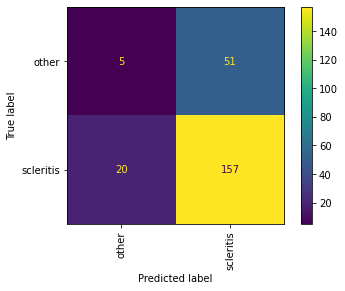

In [84]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20,40,60]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0, use_label_encoder=False)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    print(f'Standarddeviation Score: {bv.cv_results_["std_test_score"][bv.best_index_]}')

    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=lab.classes_,
                          xticks_rotation='vertical');
    
    return bv.best_estimator_
    
xgb_anterior = xgb_model(X_train_anterior, X_test_anterior, y_train_anterior_enc, y_test_anterior_enc)

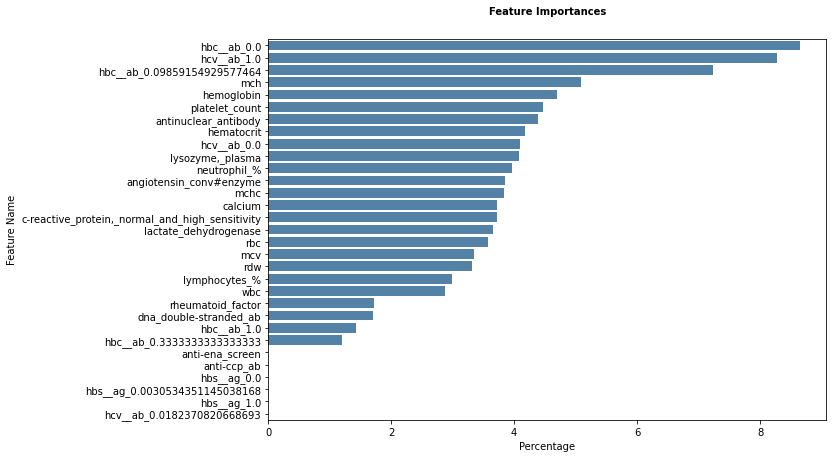

In [85]:
plot_featureimportance(xgb_anterior)

In [ ]:
xgb_intermediate = xgb_model(X_train_intermediate, X_test_intermediate, y_train_intermediate_enc, y_test_intermediate_enc)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
plot_featureimportance(xgb_intermediate)

In [ ]:
xgb_panuveitis = xgb_model(X_train_panuveitis, X_test_panuveitis, y_train_panuveitis_enc, y_test_panuveitis_enc)

In [ ]:
plot_featureimportance(xgb_panuveitis)

In [ ]:
xgb_posterior = xgb_model(X_train_posterior, X_test_posterior, y_train_posterior_enc, y_test_posterior_enc)

In [ ]:
plot_featureimportance(xgb_posterior)

In [ ]:
xgb_scleritis = xgb_model(X_train_scleritis, X_test_scleritis, y_train_scleritis_enc, y_test_scleritis_enc)

In [ ]:
plot_featureimportance(xgb_scleritis)